#### SPA6330: Artificial Intelligence and Machine Learning
#### MO: Dr Linda Cremonesi

# Midterm Project - Identifying Pulsars

## Deadline: 7th March 2025 23.59

<hr style="border:2px solid gray">

## Expectations

This assessment is worth 25% of the final module mark.

All projects are required to be submitted as Jupyter Notebooks with accompanying PDFs. If no code is provided, the project will be graded at zero. If the code provided doesn’t reproduce the work shown in the report, only the sections with the working code will be marked.



<hr style="border:2px solid gray">

## Problem formulation:
This week we are identifying pulsars using a modified version of the following dataset: Lyon,Robert. (2017). HTRU2. UCI Machine Learning Repository. https://doi.org/10.24432/C5DK6R.

The dataset features represent the statistical properties of the integrated pulsed profile and DM-SNR curve.

1. Mean of the integrated profile.
2. Standard deviation of the integrated profile.
3. Excess kurtosis of the integrated profile.
4. Skewness of the integrated profile.
5. Mean of the DM-SNR curve.
6. Standard deviation of the DM-SNR curve.
7. Excess kurtosis of the DM-SNR curve.
8. Skewness of the DM-SNR curve.

The last column tells you if the instance refers to a pulsar (1) or not (0). 

*Define the problem that you want to solve. What are you trying to predict or classify? Give an overview of the background of the problem. [/5]*
 - *Dataset [/2]:  The dataset is appropriate to address the problem*
 - *Overview [/3]:  A clear overview of the background of the problem is given, including why a machine learning model is suitable to address it* 




I aim to classify pulsar candidates with supervised learning through a binary classification model. The goal is to identify a function that maps the dataset's input features to the output labels which distinguish between pulsars and non-pulsars. A pulsar is a rapidly rotating, highly magnetised neutron star which emits electromagnetic radiation. Typically, the astronomical data collected during the process of searching for pulsar candidates includes a significant amount of non-pulsar signals as well as radio frequency interference from human-made sources like communication signals. This results in millions of candidates making it challenging to differentiate real pulsar signals and impractical to rely on manual identification. Machine learning techniques can improve accuracy and efficiency of the detection process. The HTRU2 dataset contains data of an appropriate size with relevant features from the High Time Resolution Universe Survey, making it a suitable input for training a machine learning model in this context.

<hr style="border:2px solid gray">

## Data preparation and feature engineering: 
*Prepare the data for training, such as cleaning and transforming it. This may involve removing outliers, imputing missing values, and normalising the data. Select the features that are most important for the problem. This may involve creating new features or removing irrelevant features. Use data visualisation to help inform your choices. [/25]*

 -  *Code [/10]: the code works; it is well-written, formatted, and appropriately explained.*
 -	*Figures [/10]: the figures are relevant to the tasks, they have legends and axis titles, and the figures are easily readable and interpretable.*
 -	*Text [/5]: the text justifies the preprocessing appropriately.*


In [431]:
# Load all necessary libraries at the beginnning
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas.plotting as pdp
from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn import preprocessing
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline

#### 1. Input

In [432]:
# Load data from the csv file into a pandas dataframe
data = pd.read_csv("Pulsars.csv", header=None)

#### 2. Readability

In [433]:
# View data for any obvious issues
data.head()

,0,1,2,3,4,5,6,7,8
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0.0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0.0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0.0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0.0
4,88.726562,40.672225,NaN,1.123492,1.178930,11.468720,14.269573,252.567306,0.0


In [434]:
# Fix the column headings to be appropriate and descriptive
data.columns = ['mean_int_prof', 
                'std_int_prof', 
                'excess_kurtosis_int_prof', 
                'skew_int_prof', 
                'mean_curve', 'std_curve', 
                'excess_kurtosis_curve', 
                'skew_curve', 
                'class_label']

In [435]:
# Make sure the features have corresponding meaningful titles for future visualisations.
titles = {
    "mean_int_prof": "Mean of the Integrated Profile",
    "std_int_prof": "Standard Deviation of the Integrated Profile",
    "excess_kurtosis_int_prof": "Excess Kurtosis of the Integrated Profile",
    "skew_int_prof": "Skewness of the Integrated Profile",
    "mean_curve": "Mean of the DM-SNR Curve",
    "std_curve": "Standard Deviation of the DM-SNR Curve",
    "excess_kurtosis_curve": "Excess Kurtosis of the DM-SNR Curve",
    "skew_curve": "Skewness of the DM-SNR Curve",
    "class_label": "Class Label (Pulsar or Non-Pulsar)"
}

#### 3. Missing Values

In [436]:
print("The numbers of missing values per column are:")
data.isnull().sum()

The numbers of missing values per column are:


mean_int_prof               184
std_int_prof                174
excess_kurtosis_int_prof    200
skew_int_prof               185
mean_curve                  170
std_curve                   172
excess_kurtosis_curve       165
skew_curve                  178
class_label                 177
dtype: int64

In [437]:
print("The total number of missing values is:")
missing_data = data.isnull().sum().sum()
print(missing_data)

The total number of missing values is:
1605


In [438]:
# Drop records that contain missing values specifically in the class_label column.
data = data.dropna(subset=['class_label'])

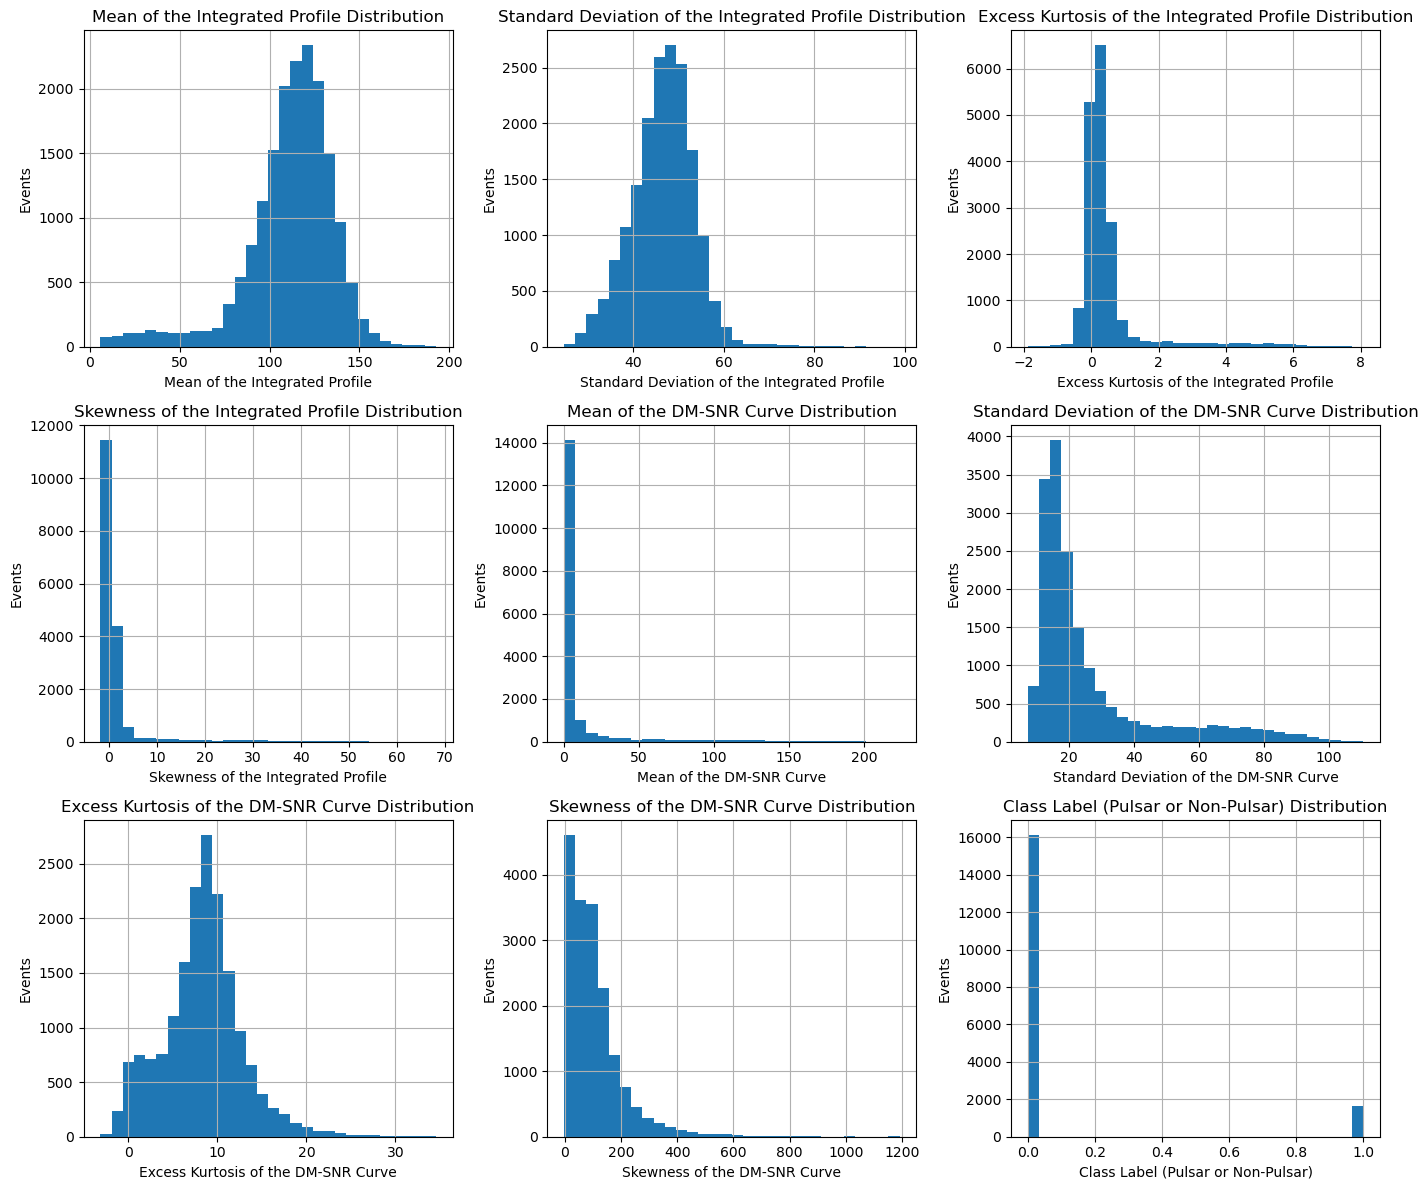

In [439]:
# Review the distributions of the features 
data.hist(figsize=(14,12), bins=30)
for ax in plt.gcf().axes:
    col_name = ax.get_title()
    ax.set_title(f"{titles.get(col_name, col_name)} Distribution")
    ax.set_xlabel(titles.get(col_name, col_name))
    ax.set_ylabel("Events")

plt.tight_layout()
plt.show()

In [440]:
# Perform median imputation
data.fillna(data.median(), inplace=True)

#### 4. Outliers

In [441]:
print("The shape of the dataframe before removing outliers:")
data.shape

The shape of the dataframe before removing outliers:


(17721, 9)

In [442]:
# Calculate z scores for the data
z_scores = stats.zscore(data)

In [443]:
# Assess the number of outliers that are 3 sigma away from the mean
outlier_counts = (np.abs(z_scores) >= 3).sum(axis=0)
print("Number of outliers per feature at a 3 sigma level:")
print("")
print(outlier_counts)
print("")
print(f"Total number of outliers at a 3 sigma level: {outlier_counts.sum()}")

Number of outliers per feature at a 3 sigma level:

mean_int_prof                452
std_int_prof                 106
excess_kurtosis_int_prof     633
skew_int_prof                519
mean_curve                   644
std_curve                    416
excess_kurtosis_curve        156
skew_curve                   334
class_label                 1622
dtype: int64

Total number of outliers at a 3 sigma level: 4882


In [444]:
# Assess the number of outliers that are 5 sigma away from the mean
z_scores = stats.zscore(data)
outlier_counts = (np.abs(z_scores) >= 5).sum(axis=0)
print("Number of outliers per feature at a 5 sigma level:")
print("")
print(outlier_counts)
print("")
print(f"Total number of outliers at a 5 sigma level: {outlier_counts.sum()}")

Number of outliers per feature at a 5 sigma level:

mean_int_prof                 0
std_int_prof                 18
excess_kurtosis_int_prof    160
skew_int_prof               231
mean_curve                  156
std_curve                     0
excess_kurtosis_curve        13
skew_curve                   88
class_label                   0
dtype: int64

Total number of outliers at a 5 sigma level: 666


In [445]:
# Remove outliers at a 5 sigma level
data = data[(np.abs(z_scores) <5).all(axis=1)]

In [446]:
print("The shape of the dataframe after removing extreme outliers:")
data.shape

The shape of the dataframe after removing extreme outliers:


(17239, 9)

#### 5. Feature Selection

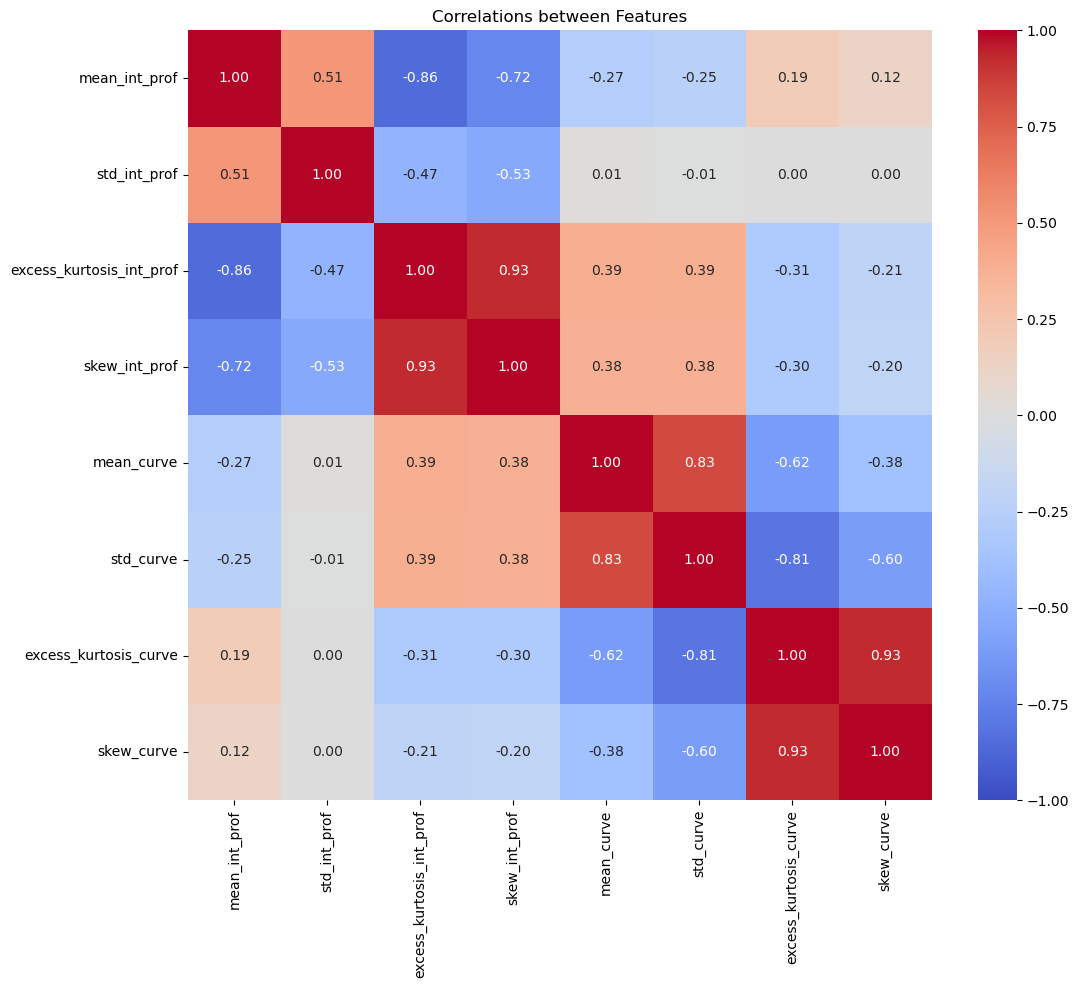

In [447]:
# Review the correlations between features to assess redundancy
corr_matrix = data.iloc[:,:-1].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlations between Features")
plt.show()

In [448]:
# Remove redundant features
data = data.drop(["skew_int_prof", "skew_curve"], axis=1)

#### 6. Feature Preparation

In [449]:
# Cast the class labels into integers
data["class_label"] = data["class_label"].astype(int)

In [450]:
# Separate out the targets
targets = data["class_label"]
data = data.drop(["class_label"], axis=1)

In [451]:
# Define the train-test split using random_state=3 for reproducibility
Xtrain, Xtest, ytrain, ytest = train_test_split(data,targets,random_state=3, train_size=0.8, test_size=0.2)

First, I initialised a pandas DataFrame and assigned descriptive column names for better readability. 

Then, I reviewed the number of missing values in the dataset. The 'class_label' feature contained 177 missing values. Imputing missing values for this column would introduce artificial data and reduce the model’s ability to learn from known patterns. This could have a significant negative impact on model performance and also distort evaluation metrics, that rely on correctly labeled instances, such as True Positive (TP) and True Negative (TN) rates. So, I decided that dropping these records was the most appropriate approach. For the other columns I chose imputation to preserve the statistical power of the dataset. After reviewing the distributions of each feature, all features displayed significant skews in their distributions. Extreme values in the long tails can disproportionately influence the means, shifting them away from the true central tendency of each feature. This meant, median imputation was the better choice, as it more accurately represents the central tendency of the distribution because it is less affected by skew.

I looked at the number of outliers at a 3 sigma level as is standard for scientific research level datasets, totalling 4,882 outliers. Removinall of g them would result in a substantial loss of statistical power, so instead I focused on the more extreme outliers at the 5-sigma level. This represented a more balanced trade-off between preserving statistical power and mitigating the influence of extreme valu so o these 666 records were dropped.

The next step was to evaluate the importance of each feature using correlations. This showed that excess kurtosis and skewnles exhibited strong correlations with each othndl as wral other features. This means the model could achieve a similar learning effect while retaining only one of these variabwhile and imingrove computational efficiency by eliminating redundancy. Additionally, by reducing the number of variables, we reduce the risk of systematic effects from individual features propagating through the model and negatively impacting overall predicti After analysing the outliers and missing values, I retained the excess kurtosis variables as they had fewer than the skew variables. ns. The mean and standard deviation variables also show strong correlations; however, this is expected as one is mathematically derived from the other. Despite this they represent distiquantitiesdata and therefore both variables were retained.

Lastly, I separated the class_label column from the full dataset so as the model was trained without directly seeing the target labels to prany event data leakage and implemented an 80-20 train-test plit.



<hr style="border:2px solid gray">

## Model selection and training: 
*Choose the machine learning algorithm and justify your choice. Explain how the algorithm works (including a diagram). Train the algorithm with default parameters and evaluate the default model with suitable metrics. [/20]*

 - *Code [/10]: the code works; it is well-written, formatted, and appropriately explained.*
 - *Figures [/5]: a diagram of the method is presented and clearly interpretable.*
 - *Text [/5]: the text explains why the model was chosen, how it works, advantages and drawbacks.*


##### Model Choice: K-Nearest Neighbours

I will employ the K-nearest neighbours algorithm. This model is underpinned by the idea that similar data points are likely to belong to the same class. KNN classifies an unknown data point by identifying the K closest data points in the feature space. It then assigns the most common class among these neighbors to the unknown data point.

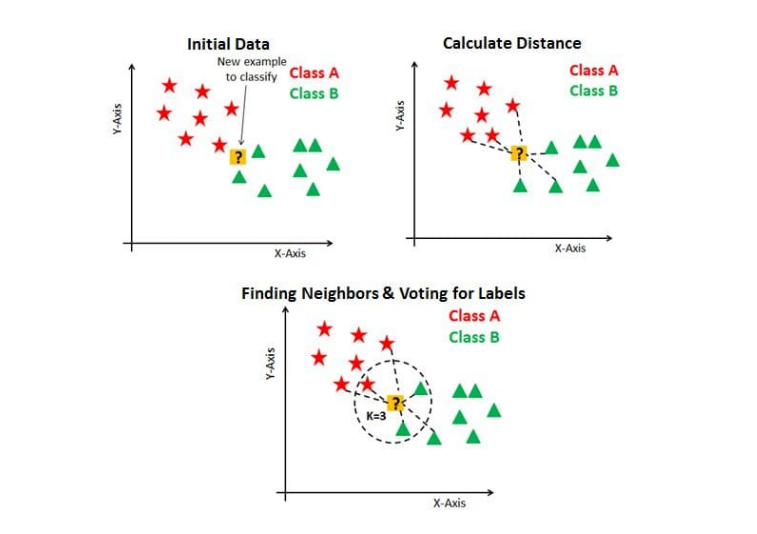

Figure 1: Diagram of the KNN process (Source: Lecture notes)

This model was chosen because it is interpretable, simple to implement, and its non-parametric nature means it doesn't rely on any assumptions about the underlying data. Most importantly, because it relies on distance metrics, it is well-suited for the continuous nature of the statistical features in the pulsar dataset. However, when the dataset is imbalanced, as is the case here, the nearest neighbors of the minority class instance are more likely to be misclassified because of the higher frequency of the majority class. Lastly, KNN is more computationally expensive than simpler algorithms like decision trees, so the cost of this will have to be assessed during model evaluation. 

In [452]:
# Initialise the standard scaler 
scaler = preprocessing.StandardScaler()
scaler.fit(Xtrain)

StandardScaler()

In [453]:
# Scale the training set
scaledXtrain = scaler.transform(Xtrain)

In [454]:
# Scale the test set
scaledXtest = scaler.transform(Xtest)

In [455]:
# Apply the classifier to the scaled data
model = KNeighborsClassifier()
model.fit(scaledXtrain,ytrain)

KNeighborsClassifier()

In [456]:
ytrainpred = model.predict(scaledXtrain)
ytestpred = model.predict(scaledXtest)

In [457]:
# Calculate the accuracy of the train and test set (default model)
train_accuracy =  metrics.accuracy_score(y_true=ytrain, y_pred=ytrainpred, normalize=True, sample_weight=None)
test_accuracy  = metrics.accuracy_score(y_true=ytest, y_pred=ytestpred, normalize=True, sample_weight=None)
print("The accuracy of the train set is {:.3f}".format(train_accuracy))
print("The accuracy of the test set is {:.3f}".format(test_accuracy))

The accuracy of the train set is 0.982
The accuracy of the test set is 0.977


In [458]:
# Calculate the precision of the train and test (default model)
train_precision =  metrics.precision_score(y_true=ytrain, y_pred=ytrainpred, sample_weight=None)
test_precision  = metrics.precision_score(y_true=ytest, y_pred=ytestpred, sample_weight=None)
print("The precision of the train set is {:.3f}".format(train_precision))
print("The precision of the test set is {:.3f}".format(test_precision))

The precision of the train set is 0.942
The precision of the test set is 0.940


In [459]:
# Calculate the recall of the train and test (default model)
train_recall =  metrics.recall_score(y_true=ytrain, y_pred=ytrainpred, sample_weight=None)
test_recall  = metrics.recall_score(y_true=ytest, y_pred=ytestpred, sample_weight=None)
print("The recall of the train set is {:.3f}".format(train_recall))
print("The recall of the test set is {:.3f}".format(test_recall))

The recall of the train set is 0.824
The recall of the test set is 0.773


Number of True Negatives: 3152.000
Number of True Positives: 218.000
Number of False Negatives: 64.000
Number of False Positives: 14.000


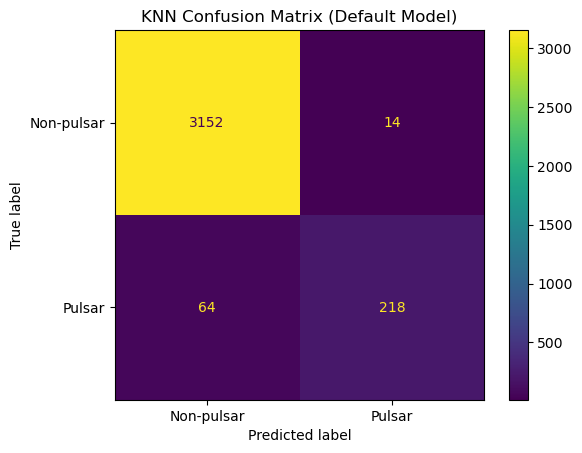

In [460]:
# Calculate the Confusion Matrix for the default model # needs title
cm = metrics.confusion_matrix(ytest,ytestpred, labels=model.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=['Non-pulsar','Pulsar'])
disp.plot()
disp.ax_.set_title("KNN Confusion Matrix (Default Model)")

print("Number of True Negatives: {:.3f}".format(cm[0,0]))
print("Number of True Positives: {:.3f}".format(cm[1,1]))
print("Number of False Negatives: {:.3f}".format(cm[1,0]))
print("Number of False Positives: {:.3f}".format(cm[0,1]))

Before training, the data was transformed using StandardScaler to ensure all of the features are on a comparable scale without altering their distribution. This is necessary for distance-based algorithms like KNN. Without scaling, variables with larger numerical ranges could disproportionately influence the distance computations and bias the results of the model.

After fitting the model, I assessed the model's performance using the accuracy, precision, and recall scores, and the confusion matrix. These scores show strong model performance, with no indication of overfitting or underfitting. There is high accuracy on both the training set and the test set, indicating that it generalises well to unseen dataSimilarly, t The precision scores for both the training and test sets tell us that the model makes only a few false positive predictions. Recall is the lowest metric of the three, particularly on the test set (0.773 compared to 0.824 in training), indicating that the model struggles to correctly identify all relevant instances. There is an inherent trade-off between precision and recall so trying to fix this m come at aay coon. The confusion matrix visualises this we, t shingws that the model is highly effective at correctly identifying non-pulsars with limited misclassifications, however it struggles much more when classifying pulsars. Thialso s aligns well with the effects expected due to the class imbalanc.


<hr style="border:2px solid gray">

## Model evaluation: 
*Choose a cross-validation strategy and appropriate metrics to evaluate the model performance. Make at least two plots to demonstrate the performance of your model. [/25]*
- *Code [/10]: the code works; it is well-written, formatted, and appropriately explained.*
- *Figures [/10]: the figures are relevant to the tasks, they have legends and axis titles, and the figures are easily readable and interpretable.*
- *Text [/5]: the text interprets the results of the cross validation with a diagnosis of possible problems.*


In [461]:
# Apply stratified cross validation
cv = StratifiedKFold(shuffle = True, n_splits = 5, random_state=5) 

In [462]:
print('Stratified Cross Validation Metric Scores')
print('----------------------------------------')

scores = cross_validate(model, data, targets, cv=cv, scoring='accuracy', return_train_score=True)
print("Accuracy train score: {:.3f} +/- {:.4f}".format(scores['train_score'].mean(), scores['train_score'].std()))
print("Accuracy test score: {:.3f} +/- {:.4f}".format(scores['test_score'].mean(), scores['test_score'].std()))
print("Fit time: {:.3f} +/- {:.4f} seconds".format(scores['fit_time'].mean(), scores['fit_time'].std()))
print('')

scores = cross_validate(model, data, targets, cv=cv, scoring='recall', return_train_score=True)
print("Recall train score: {:.3f} +/- {:.4f}".format(scores['train_score'].mean(), scores['train_score'].std()))
print("Recall test score: {:.3f} +/- {:.4f}".format(scores['test_score'].mean(), scores['test_score'].std()))
print("Fit time: {:.3f} +/- {:.4f} seconds".format(scores['fit_time'].mean(), scores['fit_time'].std()))
print('')

scores = cross_validate(model, data, targets, cv=cv, scoring='precision', return_train_score=True)
print("Precision train score: {:.3f} +/- {:.4f}".format(scores['train_score'].mean(), scores['train_score'].std()))
print("Precision test score: {:.3f} +/- {:.4f}".format(scores['test_score'].mean(), scores['test_score'].std()))
print("Fit time: {:.3f} +/- {:.4f} seconds".format(scores['fit_time'].mean(), scores['fit_time'].std()))


Stratified Cross Validation Metric Scores
----------------------------------------
Accuracy train score: 0.975 +/- 0.0004
Accuracy test score: 0.971 +/- 0.0017
Fit time: 0.014 +/- 0.0014 seconds

Recall train score: 0.771 +/- 0.0047
Recall test score: 0.741 +/- 0.0092
Fit time: 0.014 +/- 0.0009 seconds

Precision train score: 0.904 +/- 0.0048
Precision test score: 0.869 +/- 0.0223
Fit time: 0.013 +/- 0.0006 seconds


In [463]:
y_predicted_probs = model.predict_proba(scaledXtest)[:, 1]

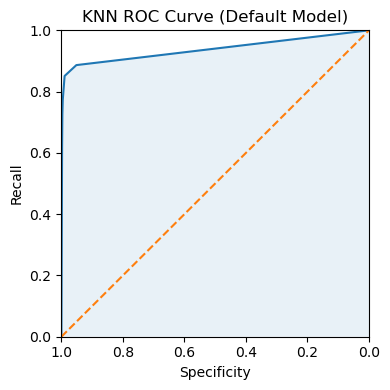

In [464]:
# ROC curve 
fpr, tpr, thresholds = roc_curve(ytest, y_predicted_probs)
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
ax.plot((1, 0), (0, 1), linestyle="--")
ax.set_title("KNN ROC Curve (Default Model)")
ax.set_xlabel('Specificity')
ax.set_ylabel('Recall')
ax.fill_between(roc_df.specificity, 0, roc_df.recall, alpha=0.1)
plt.tight_layout()
plt.show()

In [465]:
print(f"The AUC score for the model is: {round(np.sum(roc_df.recall[:-1] * np.diff(1 - roc_df.specificity)),3)}")

The AUC score for the model is: 0.882


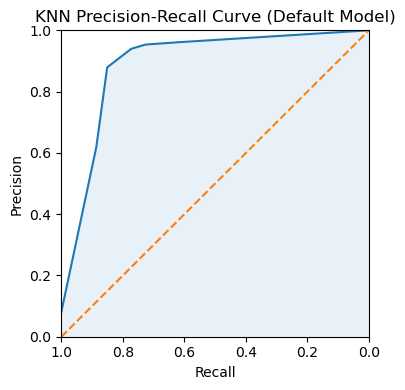

In [466]:
# Precision Recall Curve
precision, recall, thresholds = precision_recall_curve(ytest, y_predicted_probs)
pr_df = pd.DataFrame({'recall': recall, 'precision': precision})

ax = pr_df.plot(x='recall', y='precision', figsize=(4, 4), legend=False)
ax.set_title("KNN Precision-Recall Curve (Default Model)")
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)  
ax.plot((1, 0), (0, 1), linestyle="--")
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.fill_between(pr_df.recall, 0, pr_df.precision, alpha=0.1)
plt.tight_layout()
plt.show()

I used Stratified K-Fold Cross-Validation because it maintains the same proportion of class labels in each fold as in the overall dataset. Due to the class imbalance this is very important, as a standard K-Fold split may create training folds dominated by the majority class, biasing evaluation and reducing generalisation in minority class instances.

The updated model performance accuracy closely aligns with the previous assessment, still indicating consistently high accuracy with 0.975 ± 0.0004 on the training set and 0.971 ± 0.0017 on the test set. There are some slight differences in recall and precision which shothat w the tra-off hasde slightly shifted. Thw fit timis consistently low, e demonstringes computational efficien andy, addressing concerns about KNN's scalability on larger dataset.


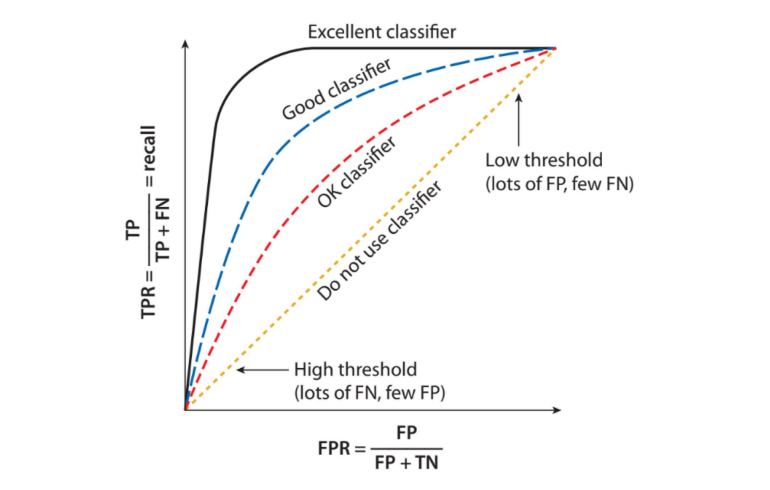

Figure 2: ROC Curve Performance Benchmark chart (Source: Lecture Notes)

The model's ROC curve falls between the "Good" and "Excellent" classifier range, indicating strong discriminatory power and the AUC score supports this, indicating that the model performs significantly better than random guessing (0.5). The Precision-Recall curve confirms that while the model is precise, it sacrifices recall (shown by how the model does not reach the upper-left corner of the graph). 
The evaluation confirms the model's suitability for the data while highlighting areas for improvement. This motivates further fine-tuning of KNN hyperparameters, such as K values..


<hr style="border:2px solid gray">

## Model tuning: 
*Use the learning curves to tune the hyperparameters of the model to improve its performance. [/20]*
- *Code [/10]: the code works; it is well-written, formatted, and appropriately explained*
- *Figures [/10]: the figures are relevant to the tasks, they have legends and axis titles, and the figures are easily readable and interpretabl*
- *Text [/5]: the text justifies the tuning of the hyper parameters appropriate*ly.


In [467]:
# Vary K hyperparameter: k=3, k=5, k=7, k=10
knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_7 = KNeighborsClassifier(n_neighbors=7)
knn_10 = KNeighborsClassifier(n_neighbors=10)

In [468]:
# Create a pipelines to scale the data for each hyperparameter variation
pipeline_knn_3 = Pipeline([('transformer', scaler), ('estimator', knn_3)])
pipeline_knn_5 = Pipeline([('transformer', scaler), ('estimator', knn_5)])
pipeline_knn_7 = Pipeline([('transformer', scaler), ('estimator', knn_7)])
pipeline_knn_10 = Pipeline([('transformer', scaler), ('estimator', knn_10)])

In [469]:
# Testing hyperparameter: k=3
train_sizes, train_scores, test_scores = learning_curve(estimator = pipeline_knn_3, X = data, y = targets, 
    cv = 5, train_sizes=np.linspace(0.1, 1.0, 5), scoring = 'recall')

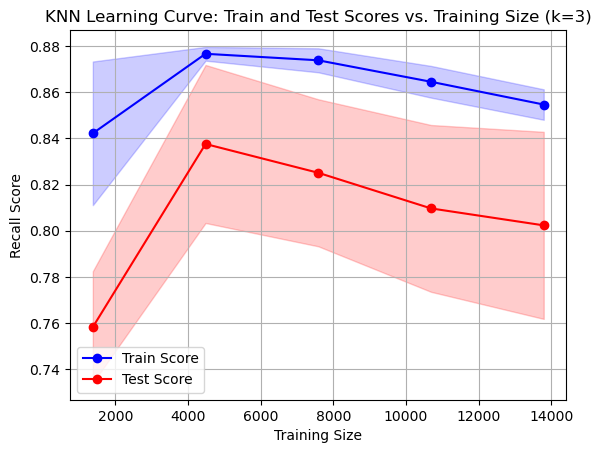

In [470]:
# Plot learning curve (k=3)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, 'o-', color='blue', label="Train Score")
plt.plot(train_sizes, test_mean, 'o-', color='red', label="Test Score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='red', alpha=0.2)

plt.xlabel("Training Size")
plt.ylabel("Recall Score")
plt.title("KNN Learning Curve: Train and Test Scores vs. Training Size (k=3)")
plt.legend()
plt.grid(True)
plt.show()

In [471]:
# Test hyperparameter: k=5
train_sizes, train_scores, test_scores = learning_curve(estimator = pipeline_knn_5, X = data, y = targets, 
    cv = 5, train_sizes=np.linspace(0.1, 1.0, 5), scoring = 'recall')

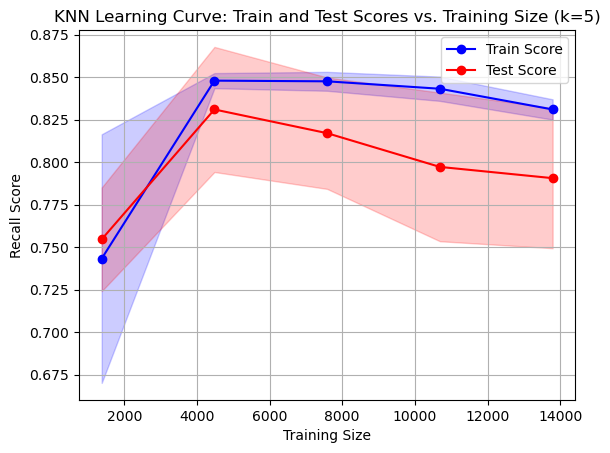

In [472]:
# Plot learning curve (k=5)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, 'o-', color='blue', label="Train Score")
plt.plot(train_sizes, test_mean, 'o-', color='red', label="Test Score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='red', alpha=0.2)

plt.xlabel("Training Size")
plt.ylabel("Recall Score")
plt.title("KNN Learning Curve: Train and Test Scores vs. Training Size (k=5)")
plt.legend()
plt.grid(True)
plt.show()

In [473]:
# Test hyperparameter: k=7
train_sizes, train_scores, test_scores = learning_curve(estimator = pipeline_knn_7, X = data, y = targets, 
    cv = 5, train_sizes=np.linspace(0.1, 1.0, 5), scoring = 'recall')

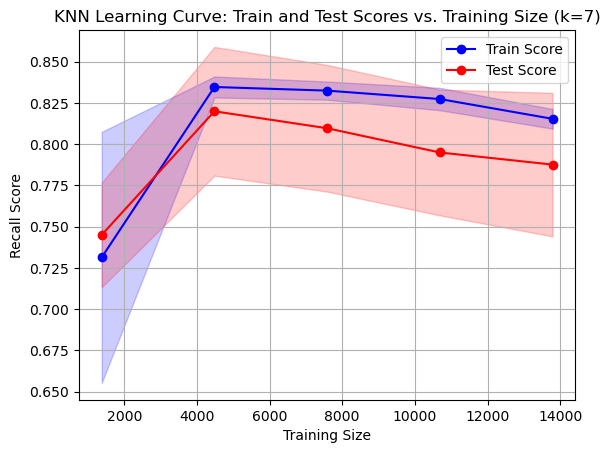

In [474]:
# Plot learning curve (k=7)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, 'o-', color='blue', label="Train Score")
plt.plot(train_sizes, test_mean, 'o-', color='red', label="Test Score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='red', alpha=0.2)

plt.xlabel("Training Size")
plt.ylabel("Recall Score")
plt.title("KNN Learning Curve: Train and Test Scores vs. Training Size (k=7)")
plt.legend()
plt.grid(True)
plt.show()

In [475]:
# Test hyperparameter: k=10
train_sizes, train_scores, test_scores = learning_curve(estimator = pipeline_knn_10, X = data, y = targets, 
    cv = 5, train_sizes=np.linspace(0.1, 1.0, 5), scoring = 'recall')

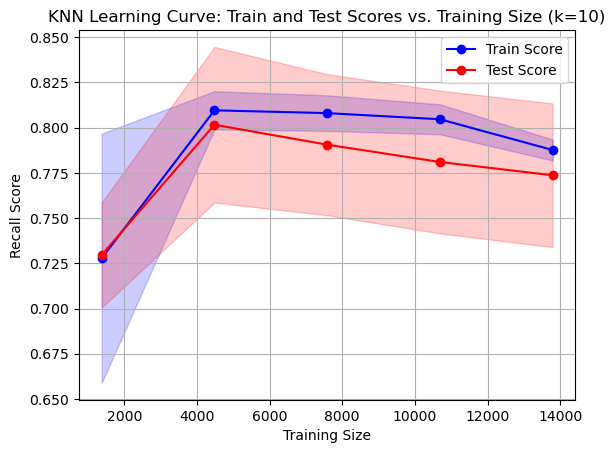

In [476]:
# Plot learning curve (k=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, 'o-', color='blue', label="Train Score")
plt.plot(train_sizes, test_mean, 'o-', color='red', label="Test Score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='red', alpha=0.2)

plt.xlabel("Training Size")
plt.ylabel("Recall Score")
plt.title("KNN Learning Curve: Train and Test Scores vs. Training Size (k=10)")
plt.legend()
plt.grid(True)
plt.show()

Recall is the best metric to optimise to enhance correct pulsar classification performance as it measures the proportion of pulsars correctly identified. As training size increases, train and test scores converge, with performance peaking around 4,000–6,000 samples before slightly declining, suggesting this as the optimal training size. 

K=3:
The model achieves high recall on the training set, but its performance declines significantly on the test set. The large gap between training and test scores indicates substantial overfitting.

K=5:
This model's train score is slightly lower than K=3, but the test recall is higher which indicates this model generalises better and does not have the same overfitting issue that K=3 has. However, as the training size increases, the test recall gradually declines, indicating that the model's ability to generalise weakens with more data and the model begin to show signs of overfitting.

K=7: The Optimal Choice
This model performs similarly to K=5 on the training set but maintains higher recall on the test set as the training size grows. This valuable improvement suggests that K=7 achieves the best balance between overfitting and generalisation.

K=10:
Although the model still performs well, it does not show measurable improvement over K=7. Since increasing K also increases computational complexity, using K=10 would lead to unnecessary computation without a clear performance benefit.

<hr style="border:2px solid gray">

## Conclusion: 
*Explain how you would improve the model if you had more time. [/5]*



To improve the model, I would adjust the training size to 4,000–6,000 samples and fit the final model using K=7, as identified in the fine-tuning. Additionally, I would refine other hyperparameters alongside K. For example, the distance metric could be adjusted between Euclidean, Manhattan, and Minkowski to determine the most effective measure for the model.

If this did not lead to significant improvement, I would revisit feature selection and determine whether the dropped skewness features could be replaced with more informative features, I wou also d review the input data qualit,  particularly focusing on addressing the class imbalance. One potential approach would be upsampling the minority pulsar class to ensure the model learns from a more balanced dataset, thereby improving recal.


<hr style="border:2px solid gray">

## Word count

Run the cell below to get a word count of the Markdown cells.

In [477]:
import io
from nbformat import current

filepath='MidtermProject_2025_Pulsars.ipynb'

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_instructions = 810
word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("The total word count (excluding instructions) is:", word_count-word_instructions)

The total word count (excluding instructions) is: 1500


your work.

<hr style="border:2px solid gray">

## Saving, downloading and uploading to QMPlus


Submission: 

 - You should submit all files needed to run your project (ie the Jupyter Notebook (.ipynb) and the dataset used as input). **Remember to run Restart kernel and Run all cells before submitting** as you want to make sure that your submission is working without issues
 - A PDF format of the successfully run Jupyter Notebook is also required.
 - Timestamps will be used to determine if they are on time.
 - All code development should be done within JupyterHub so that there is a record of the process by which you wrote your code.

To save the Jupyter notebook and the PDF go on `File`, and select `Download as` from the drop down menu, then select: `Notebook (ipynb)` to download the jupyter notebook (*Note that you won't be able to open this file from your computer, please upload it as is to QMPlus.*). Similarly, use `PDF` to download a PDF copy of your work. 

The `PDF` download is sometimes a little bit clunky, make sure you check it works well in advance to the deadline.